In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [12]:
# 1. Memuat data
# Asumsikan data Anda dalam bentuk berikut
# data = {'text': ["komentar1", "komentar2", ...], 'label': [0, 1, ...]}
data = pd.read_csv('dataset-judol-final.csv', encoding='utf-8')  # Ganti dengan path ke file dataset Anda

In [14]:
data

,label,author,comment,video_id,channel,title
0,1,lukman8584,𝙒𝙄𝘽𝙐69𝙅𝙋 Memberikan Pelayanan Terbaik Sepanjan...,153XPkkQbxo,KOMPASTV,Blak-blakan! Menteri ESDM Bahlil soal Aturan B...
1,0,sorasore132,Dia ingin membantu rakyat tapi dengan cara yan...,153XPkkQbxo,KOMPASTV,Blak-blakan! Menteri ESDM Bahlil soal Aturan B...
2,1,nirvanasound4361,"Tiap hari ada aja hal baru di 𝐀Е𝐑𝑂𝟾𝟖, bikin pe...",153XPkkQbxo,KOMPASTV,Blak-blakan! Menteri ESDM Bahlil soal Aturan B...
3,1,asepruswandi5091,"𝘼G𝘜𝘚𝘛О𝙏О modal tipis doang, gua lngsg WEDEY gede",153XPkkQbxo,KOMPASTV,Blak-blakan! Menteri ESDM Bahlil soal Aturan B...
4,1,anwarsopian-p8j,🆂🅴🅺🅰🆁🅰🅽🅶 ❗ 🅳🅸 🅺🆄🅽🅶 🆂🅴🆁🅾🅽🅾 🅹🆄🅳🅸 🎲 🎰 𝕞𝕒𝕚𝕟 𝕡𝕠𝕜𝕖𝕣 ...,153XPkkQbxo,KOMPASTV,Blak-blakan! Menteri ESDM Bahlil soal Aturan B...
...,...,...,...,...,...,...
894,0,RahmadKunanto-ye9kl,"Mau memoermudah malah mempersulit rakyat,,",TerK02wFTz0,tvOneNews,"Warga Protes Buang Tabung Gas LPG 3 Kg, Dampak..."
895,1,willykristian8971,BURUAN ABSEN YANG UDAH PADA COBAIN 𝙒𝙄𝘽𝙐69𝙅𝙋 ?,TerK02wFTz0,tvOneNews,"Warga Protes Buang Tabung Gas LPG 3 Kg, Dampak..."
896,0,hamidahusni8307,Sangat mempersulit rakyat kecil...,TerK02wFTz0,tvOneNews,"Warga Protes Buang Tabung Gas LPG 3 Kg, Dampak..."
897,0,y_putra,sengaja bgt bikin gaduh biar pagar laut dilupa...,TerK02wFTz0,tvOneNews,"Warga Protes Buang Tabung Gas LPG 3 Kg, Dampak..."


In [15]:

# 2. Preprocessing Teks
# Tokenisasi teks
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['comment'])
sequences = tokenizer.texts_to_sequences(data['comment'])
x_data = pad_sequences(sequences, maxlen=max_len)

# Mengubah label menjadi bentuk numpy array
y_data = np.array(data['label'])

In [16]:
# 3. Membangun Model LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [17]:
# 4. Kompilasi dan Pelatihan Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Membagi data menjadi data pelatihan dan validasi
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
23/23 [==============================] - 4s 65ms/step - loss: 0.6694 - accuracy: 0.5828 - val_loss: 0.6052 - val_accuracy: 0.6667
Epoch 2/10
23/23 [==============================] - 1s 40ms/step - loss: 0.5424 - accuracy: 0.7900 - val_loss: 0.3975 - val_accuracy: 0.8944
Epoch 3/10
23/23 [==============================] - 1s 38ms/step - loss: 0.1991 - accuracy: 0.9541 - val_loss: 0.2342 - val_accuracy: 0.8778
Epoch 4/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0717 - accuracy: 0.9875 - val_loss: 0.1667 - val_accuracy: 0.9222
Epoch 5/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0302 - accuracy: 0.9930 - val_loss: 0.1846 - val_accuracy: 0.9278
Epoch 6/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0208 - accuracy: 0.9972 - val_loss: 0.1971 - val_accuracy: 0.9056
Epoch 7/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0192 - accuracy: 0.9986 - val_loss: 0.2481 - val_accuracy: 0.9000
Epoch 8/10
23

In [18]:
# 5. Evaluasi Model
loss, accuracy = model.evaluate(x_val, y_val)
print(f"Loss: {loss}, Accuracy: {accuracy}")

6/6 [==============================] - 0s 11ms/step - loss: 0.3707 - accuracy: 0.8722
Loss: 0.3707069456577301, Accuracy: 0.8722222447395325


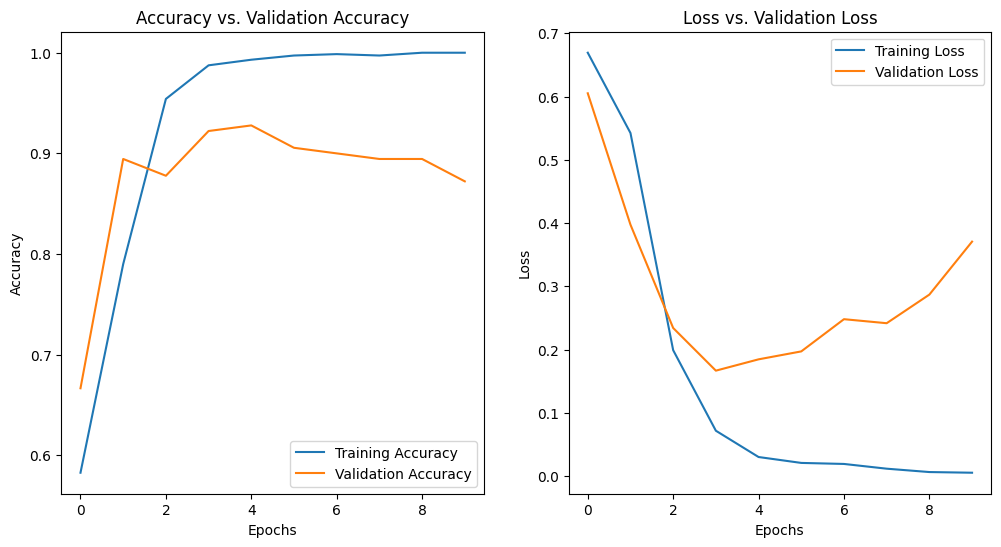

In [19]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
model.save('model.h5')

keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
